# 1. Data exploration and feature extraction

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-24 12:10:20.438404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/envs/adsml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 0. Extracting features from one image (warm-up)

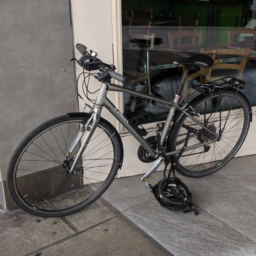

In [2]:
# take a look at the image first:

%matplotlib inline
from IPython.display import display
import PIL.Image as Image
import numpy as np

# Load image
img = Image.open("swissroads/test/bike/bike-0100.png")
display(img)

In [3]:
# Creates a batch-like structure for the single image:

img_resized = img.resize([224, 224], resample=Image.BILINEAR)  # Expected size
img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :] / 255
print("Batch size:", img_batch.shape)

# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.load(model_url)

# Extract features
features = feature_extractor(img_batch)
features.shape



Batch size: (1, 224, 224, 3)


TensorShape([1, 1280])

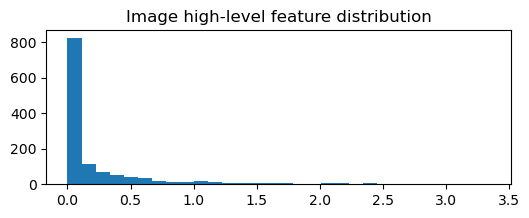

In [4]:
# plot the extracted features
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
plt.hist(features[0].numpy(), bins=30,)
plt.title("Image high-level feature distribution")
plt.show()

Observation: <br>
The extracted features are globally very small and all positive

### 1. Loading the images from the three sets (train, validation, and test). Since the images will be fed to a pretrained model for feature extraction, make sure to set the scale of the pixels and the image size as expected by the model 

In [5]:
# Directory containing the dataset
dataset_dir = "swissroads"

In [6]:
# Creating image generator for train and test, rescaling and data augmenting

train_generator = ImageDataGenerator(rescale=1/256, 
                                     horizontal_flip=True, 
                                     rotation_range=5) 
                                     
test_generator = ImageDataGenerator(rescale=1 / 256)

In [7]:
# File iterators for Train, validation and test sets (due to the folder structure)

print('trainset:')
trainset = train_generator.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=32,
    target_size=(224, 224), # from model documentation
    shuffle=True,
    subset="training"
)
print('validset:')
validset = train_generator.flow_from_directory(
    os.path.join(dataset_dir, "valid"),
    batch_size=32,
    target_size=(224, 224),
    shuffle=False
)
print('testset:')
testset = test_generator.flow_from_directory(
    os.path.join(dataset_dir, "test"), 
    batch_size=32, 
    target_size=(224, 224), 
    shuffle=False,
)

trainset:
Found 280 images belonging to 6 classes.
validset:
Found 139 images belonging to 6 classes.
testset:
Found 50 images belonging to 6 classes.


**Quick checks:** <br>
The above numbers being correct, let's still look at what we've got to check if its consisten with what is expected:

In [8]:
print('Quick check')
print('type of object: ',type(testset))
print('labels:',testset.labels)
print('labels names: ',trainset.class_indices)

# dimentions:
batch = testset[0]  # the first batch
print('shape of input images in the first batch: ',batch[0].shape)  
print('shape of labels in the first batch: ',batch[1].shape)  

#files
print('First 3 files from Train: ', trainset.filenames[:3])
print('First 3 files from Valid: ', validset.filenames[:3])
print('First 3 files from Test: ', testset.filenames[:3])

Quick check
type of object:  <class 'keras.src.preprocessing.image.DirectoryIterator'>
labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 4 4 4 4 4 4 4 5 5 5 5 5]
labels names:  {'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}
shape of input images in the first batch:  (32, 224, 224, 3)
shape of labels in the first batch:  (32, 6)
First 3 files from Train:  ['bike/bike-0001.png', 'bike/bike-0002.png', 'bike/bike-0003.png']
First 3 files from Valid:  ['bike/bike-0067.png', 'bike/bike-0068.png', 'bike/bike-0069.png']
First 3 files from Test:  ['bike/bike-0100.png', 'bike/bike-0101.png', 'bike/bike-0102.png']


Looks allright

## 2. Plot a few images from each category (bike, car, motorcycle, other, truck, van).

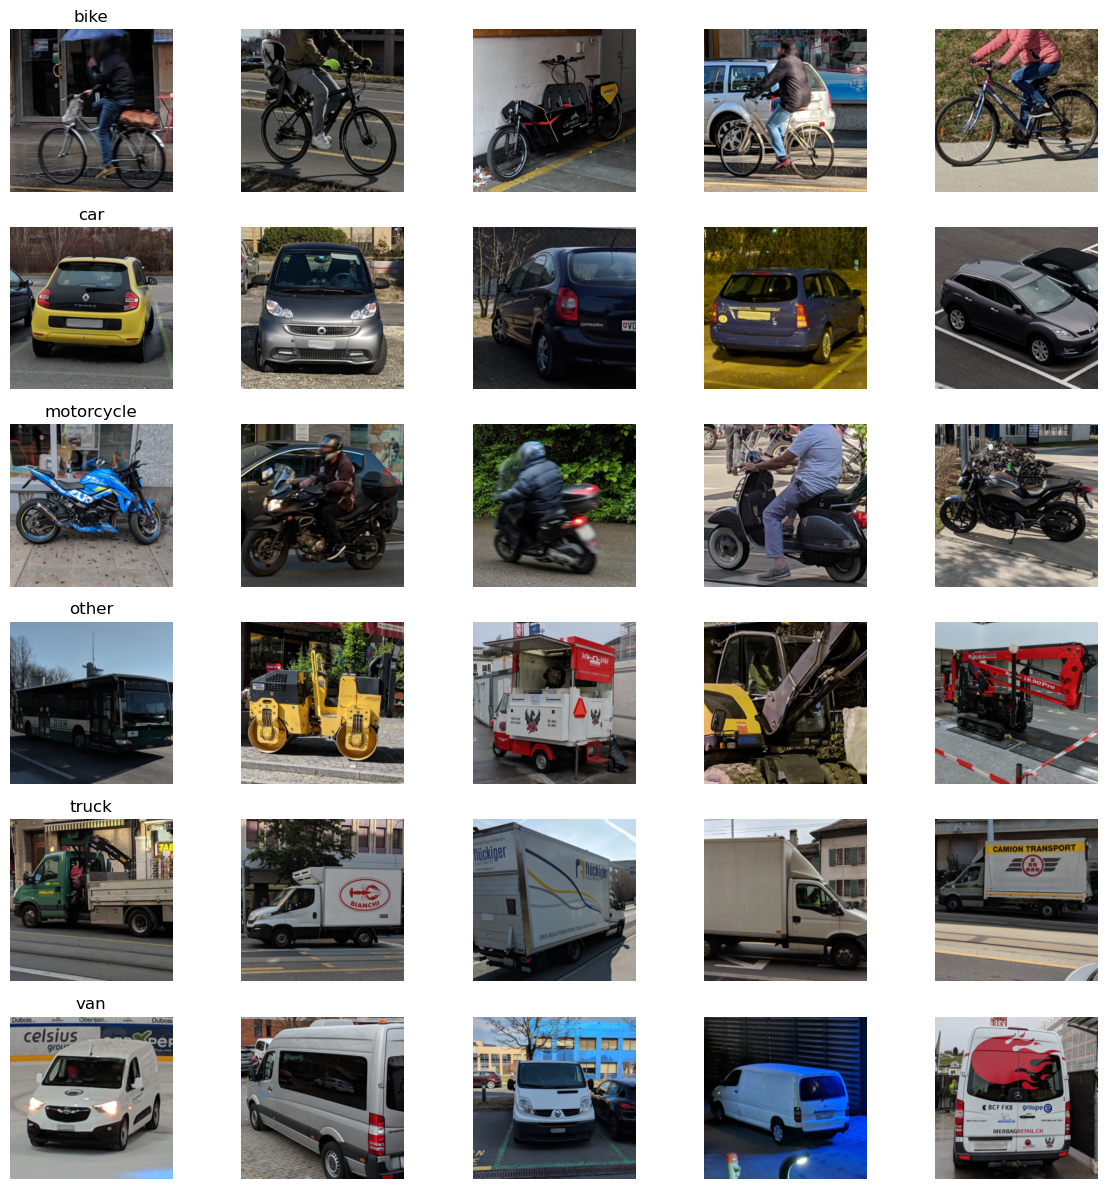

In [9]:
def plotting(dataset, categories, num_images):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(12, 12))
    for i, category in enumerate(categories):
        category_images = [os.path.join(dataset.directory, category, filename) for filename in os.listdir(os.path.join(dataset.directory, category))[:num_images]]
        for j, image_path in enumerate(category_images):
            img = plt.imread(image_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)
    plt.tight_layout()
    plt.show()

plotting(trainset, trainset.class_indices.keys(),5) # I will only plot those from the trainset
#plotting(validnset, validnset.class_indices.keys(),5)
#plotting(testset, testset.class_indices.keys(),5)

### 3. Use an appropriate visualization to show the proportions of each category in the three sets (train, validation, and test).

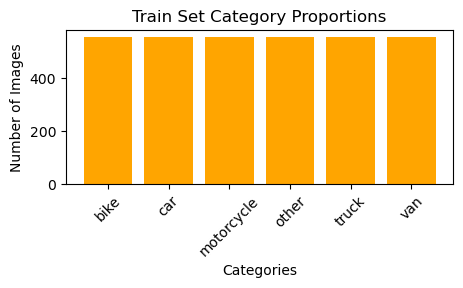

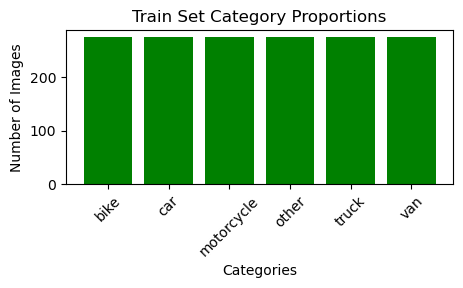

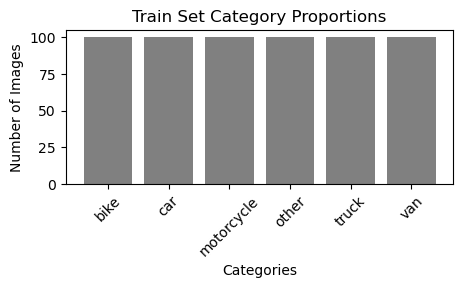

In [10]:
# Function to plot category proportions
def plot_vehicles_proportions(dataset, title, color):
    category_counts = dataset.labels.sum(axis=0)
    categories = dataset.class_indices.keys()
    plt.figure(figsize=(5, 2))
    plt.bar(categories, category_counts, color =color)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Plot category proportions for ech set
plot_vehicles_proportions(trainset, 'Train Set Category Proportions', 'orange')
plot_vehicles_proportions(validset, 'Train Set Category Proportions', 'green')
plot_vehicles_proportions(testset, 'Train Set Category Proportions', 'grey')

The images are uniformly distributed accross 6 categories in all datasets

### 4. Extract the high-level features for all the images in the three datasets using MobileNet v2. Consider storing the extracted high-level features, e.g. in npz files, for quickly reloading them into each of the following notebooks.



In [11]:
# Load MobileNet V2 feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.load(model_url)

As here we work with a large number of pictures, we need to iterate over batches of data yielded by the generator. Each batch consists of a tuple (inputs_batch, labels_batch), but we're only interested in the input images, so we only unpack the inputs_batch.

To update the feature array with the extractions from the current batch a helper "i" is used to determine the slice of features array where these features should be stored. 

In [12]:
# defining how features should be extracted (and stored) for batches of images

def extract_features(generator):
    num_samples = len(generator.filenames)
    features = np.zeros((num_samples, 1280))  # Initialize array to store features after extraction
    i = 0 # i will determins the part of features array where these features should be stored
    for inputs_batch, _ in generator: # "_" allows to discard the labels as not needed here
        features_batch = feature_extractor(inputs_batch)  
        features[i * generator.batch_size: (i + 1) * generator.batch_size] = features_batch.numpy()
        i += 1
        if i * generator.batch_size >= num_samples:
            break
    return features

In [13]:
# Actual extracting
train_features = extract_features(trainset)
valid_features = extract_features(validset)
test_features = extract_features(testset)

# Saving the results:
np.savez('train_features.npz', features=train_features)
np.savez('valid_features.npz', features=valid_features)
np.savez('test_features.npz', features=test_features)

# Additionally, saving data with labels 
train_labels = trainset.classes
valid_labels = validset.classes
test_labels = testset.classes

np.savez('labelled_train_features.npz', features=train_features, labels=train_labels)
np.savez('labelled_valid_features.npz', features=valid_features, labels=valid_labels)
np.savez('labelled_test_features.npz', features=test_features, labels=test_labels)


quick dimention check:

In [14]:
#unlabelled features data
train_features = np.load('train_features.npz')['features']
valid_features = np.load('valid_features.npz')['features']
test_features = np.load('test_features.npz')['features']
print("Train Features Shape:", train_features.shape)
print("valid Features Shape:", valid_features.shape)
print("Test Features Shape:", test_features.shape)

#labels
labels_train = np.load('labelled_train_features.npz')['labels']
labels_valid = np.load('labelled_valid_features.npz')['labels']
labels_test = np.load('labelled_test_features.npz')['labels']
print('shape of train labels: :', labels_train.shape)
print('shape of valid labels: :', labels_valid.shape)
print('shape of test labels: :', labels_test.shape)

Train Features Shape: (280, 1280)
valid Features Shape: (139, 1280)
Test Features Shape: (50, 1280)
shape of train labels: : (280,)
shape of valid labels: : (139,)
shape of test labels: : (50,)


The dimentions are as expected: <br>
* Rows correspond to the number of images in each set 
* Columns to the number of features extracted proposed by MobileNet V2 model

### 5. For each of the 6 categories in the training dataset, answer the following questions:
####  5.1 What are the top 5 features that have the highest mean value?


##### A. Calculate Mean Value of Features for Each Category

In [15]:
# Loading the training features
train_features_data = np.load("train_features.npz")
train_features = train_features_data['features']
print('shape of features: ',train_features.shape)

# Load training labels
train_labels = trainset.classes
print('shape of labels: ',train_labels.shape)

# Get the unique categories (used for the loops below)
categories = np.unique(train_labels)
print('unique labels: ', categories)

shape of features:  (280, 1280)
shape of labels:  (280,)
unique labels:  [0 1 2 3 4 5]


In [16]:
category_mean_values = {}

# Computing mean value of features for each category
for category in categories:
    category_indices = np.where(train_labels == category)[0]
    category_features = train_features[category_indices]
    category_mean = np.mean(category_features, axis=0) # calculating mean along the columns
    category_mean_values[category] = category_mean

In [17]:
# lets look at the category_mean_values dictionnary:

print('dimentions: ')
for key, values_list in category_mean_values.items():
    num_values = len(values_list)
    print("Number of values in key", key, ":", num_values)
print('')
print('values in the category 1: ', category_mean_values[0])


dimentions: 
Number of values in key 0 : 1280
Number of values in key 1 : 1280
Number of values in key 2 : 1280
Number of values in key 3 : 1280
Number of values in key 4 : 1280
Number of values in key 5 : 1280

values in the category 1:  [0.424503   0.3864722  0.20528107 ... 0.08821209 0.34497625 0.34890999]


These values represent mean values of each of the 1280 features of all images in the train set belonging to this category

##### B. Identify Top 5 Features for Each Category

In [18]:
top_5_features_per_category = {}

# Identify top 5 features within each category
for category, category_mean in category_mean_values.items():
    top_5_indices = np.argsort(-category_mean)[:5] 
    top_5_features = [(index, value) for index, value in enumerate(category_mean) if index in top_5_indices]
    top_5_features_per_category[category] = top_5_features# Storing them for the current category

In [19]:
top_5_features_per_category = {}

# Iterate over categories and its mean values
for category, category_mean in category_mean_values.items():
    top_5_indices = np.argsort(-category_mean)[:5] #sorting & extracting top 5
    
    # storing the results
    top_5_features = []
    
    for index, value in enumerate(category_mean):
        if index in top_5_indices:
            top_5_features.append((index, value))
        top_5_features_per_category[category] = top_5_features
        
top_5_features_per_category

{0: [(59, 1.1509242400131894),
  (165, 1.561191131614826),
  (257, 1.2648548165505582),
  (261, 1.33522137514118),
  (660, 1.098184256388446)],
 1: [(59, 1.3090332926949486),
  (165, 1.768633464584127),
  (257, 1.243672033342591),
  (261, 1.3513468045694026),
  (660, 1.170962605096065)],
 2: [(165, 1.95491159114731),
  (261, 1.1323163180301588),
  (660, 1.148772488749933),
  (1142, 1.1340406816817967),
  (1240, 1.1415388044335095)],
 3: [(59, 1.2524547770080972),
  (165, 1.9013028350891545),
  (261, 1.2531667664879933),
  (799, 1.2169720775345922),
  (1240, 1.048347332238336)],
 4: [(165, 1.415479475576874),
  (183, 1.190479209857239),
  (257, 1.1542495788917655),
  (660, 1.1179566254417987),
  (1240, 1.1809512314225903)],
 5: [(165, 1.4975609213113785),
  (477, 1.1799371428787708),
  (796, 1.1531420014798641),
  (799, 1.1778462845087052),
  (1218, 1.2057717853784562)]}

In [20]:
# top features (without the values)

summary = {}

# Iterate over the data dictionary
for key, value_list in top_5_features_per_category.items():
    # Extract the first element of each value list
    first_elements = [item[0] for item in value_list]
    
    # Add the key and the first elements to the summary dictionary
    summary[key] = first_elements

print('top 5 features per category: ')
print('')
for key, values_list in summary.items():
    num_values = values_list
    print("Top features in key", key, ":", num_values)

top 5 features per category: 

Top features in key 0 : [59, 165, 257, 261, 660]
Top features in key 1 : [59, 165, 257, 261, 660]
Top features in key 2 : [165, 261, 660, 1142, 1240]
Top features in key 3 : [59, 165, 261, 799, 1240]
Top features in key 4 : [165, 183, 257, 660, 1240]
Top features in key 5 : [165, 477, 796, 799, 1218]


##### 5.2 Which categories share the same most active feature (i.e. have highest means)?

Looking at the top_5_features_per_category dictionary one can see that the top 5 features here are sorted according to the feature index, sorting them according to their values would make the results easier to compare.

In [21]:
# sorting feature withing each category according to their values

sorted_data = {}

for key, values in top_5_features_per_category.items():
    sorted_values = sorted(values, key=lambda x: x[1], reverse=True)
    sorted_data[key] = sorted_values

sorted_data

{0: [(165, 1.561191131614826),
  (261, 1.33522137514118),
  (257, 1.2648548165505582),
  (59, 1.1509242400131894),
  (660, 1.098184256388446)],
 1: [(165, 1.768633464584127),
  (261, 1.3513468045694026),
  (59, 1.3090332926949486),
  (257, 1.243672033342591),
  (660, 1.170962605096065)],
 2: [(165, 1.95491159114731),
  (660, 1.148772488749933),
  (1240, 1.1415388044335095),
  (1142, 1.1340406816817967),
  (261, 1.1323163180301588)],
 3: [(165, 1.9013028350891545),
  (261, 1.2531667664879933),
  (59, 1.2524547770080972),
  (799, 1.2169720775345922),
  (1240, 1.048347332238336)],
 4: [(165, 1.415479475576874),
  (183, 1.190479209857239),
  (1240, 1.1809512314225903),
  (257, 1.1542495788917655),
  (660, 1.1179566254417987)],
 5: [(165, 1.4975609213113785),
  (1218, 1.2057717853784562),
  (477, 1.1799371428787708),
  (799, 1.1778462845087052),
  (796, 1.1531420014798641)]}

In [22]:
# again, removing the actual value to declutter

summary_sorted = {}
for key, value_list in sorted_data.items():
    first_elements = [item[0] for item in value_list]
    summary_sorted[key] = first_elements

print('top features per category - sorted from the highest : ')
print('')
for key, values_list in summary_sorted.items():
    num_values = values_list
    print("Top features in key", key, ":", num_values)

top features per category - sorted from the highest : 

Top features in key 0 : [165, 261, 257, 59, 660]
Top features in key 1 : [165, 261, 59, 257, 660]
Top features in key 2 : [165, 660, 1240, 1142, 261]
Top features in key 3 : [165, 261, 59, 799, 1240]
Top features in key 4 : [165, 183, 1240, 257, 660]
Top features in key 5 : [165, 1218, 477, 799, 796]


Interpretation: <br>
It looks like feature 165 is paramount in classification of these pictures into specific vehicle categories. Other important features present in multiple categories are 261, 59, 1120 and 257.